# License Plate Detection using YOLOv3

## Importing necessary libraries

In [33]:
from IPython.display import Image
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [34]:
input_path = r'test_dataset/images/1.jpg'

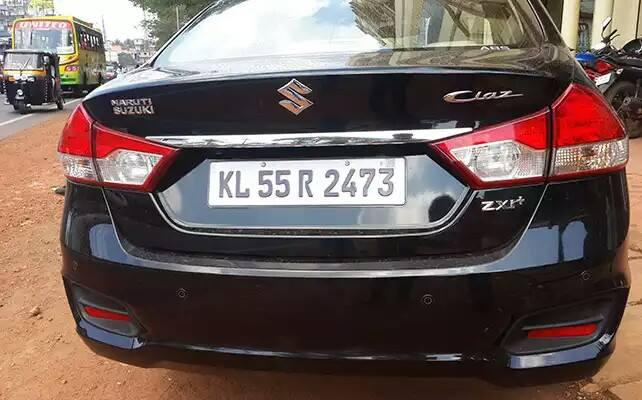

In [35]:
Image(input_path)

## Input Receiver

In [36]:
cap = cv2.VideoCapture(input_path)

## YOLO Plate Detection
### Initialize the parameters

In [37]:
confThreshold = 0.5  
nmsThreshold = 0.4  

inpWidth = 416     
inpHeight = 416     

In [38]:
classesFile = "yolo_utils/classes.names";

In [39]:
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [40]:
modelConfiguration = r"yolo_utils/darknet-yolov3.cfg";
modelWeights = r"yolo_utils/lapi.weights";

In [41]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [42]:
def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]

The following function ```drawPred()``` draws a bounding box in an image when attributes like class name, confidence, coordinates and the image itself is passed though it.

In [43]:
def drawPred(classId, conf, left, top, right, bottom, frame):
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [44]:
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        bottom = top + height
        right = left + width
        
        cropped = frame[top:bottom, left:right].copy()
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

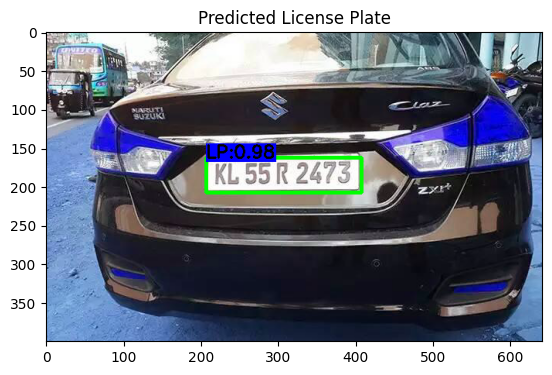

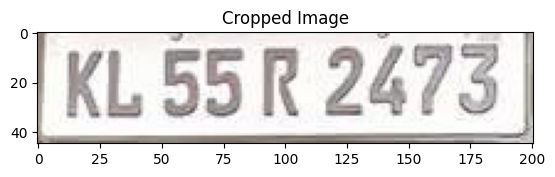

Done processing !!!


In [45]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() 

    if not hasFrame:
        print("Done processing !!!")
        break

    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    net.setInput(blob)

    outs = net.forward(getOutputsNames(net))

    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted License Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.show()

In [46]:
def find_contours(dimensions, img) :

    
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) 

            char_copy = np.zeros((44,24))
            
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            
            char = cv2.subtract(255, char)

            
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) 
            
    
            
    plt.show()
    
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

- Finding all the contours in the input image.
- After finding all the contours we consider them one by one and calculate the dimension of their respective bounding rectangle. Now consider bounding rectangle is the smallest rectangle possible that contains the contour.
  1. Width in the range 0, (length of the pic)/(number of characters) and,
  2. Length in a range of (width of the pic)/2, 4*(width of the pic)/5. 

In [47]:

def segment_characters(image) :

    
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

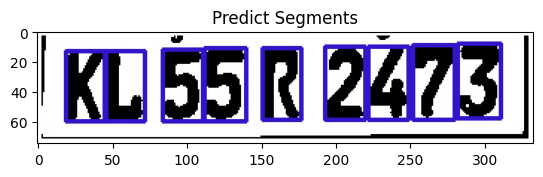

In [48]:
char=segment_characters(cropped)

In [49]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

## Character Recognition using CNN
instance of model and weights

In [50]:

loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))


loaded_model.load_weights('checkpoints/my_checkpoint')

2022-10-15 11:12:01.795503: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-10-15 11:12:01.831419: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-15 11:12:01.831449: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mk-piyush): /proc/driver/nvidia/version does not exist
2022-10-15 11:12:01.832036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Predict the license plate number

In [51]:

def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): 
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) 
        y_ = loaded_model.predict_classes(img)[0] 
        character = dic[y_]
        output.append(character) 
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

/home/piyush/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-10-15 11:12:01.972310: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-15 11:12:01.973302: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3193965000 Hz


KL55R247S


In [52]:

plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset


In [53]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

ID       NUMBER
0      1    KL55R2473
1      2  GJW115A1138
2      3    KL16J3636
3      4   MH20EE7598
4      5      PJJ1L76
..   ...          ...
181  182      DHF5B15
182  183      DBJ5R59
183  184      LVY8X45
184  185      YYD6B61
185  186      CHI4A30

[186 rows x 2 columns]

## All Testing for contour and prediction segment

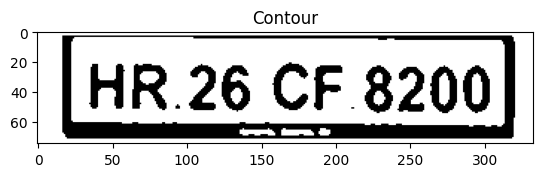

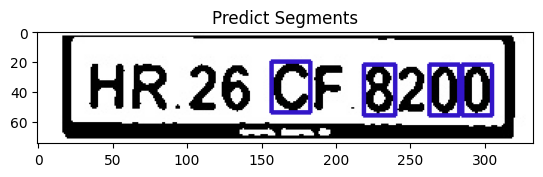

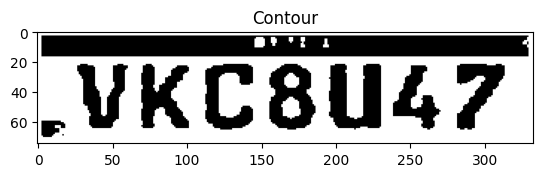

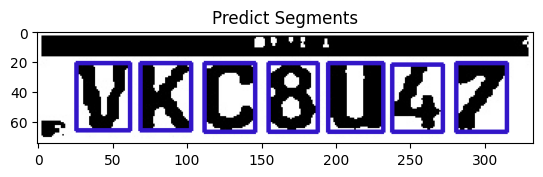

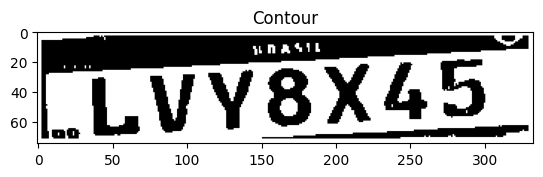

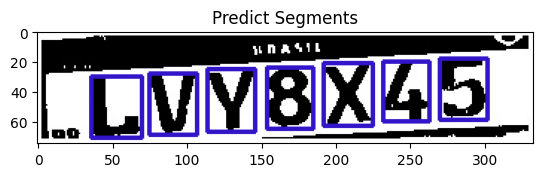

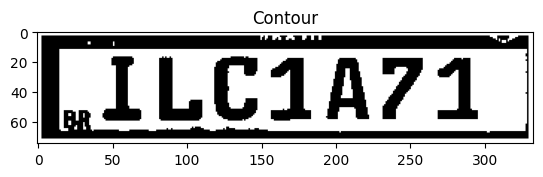

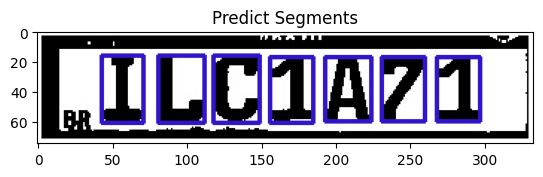

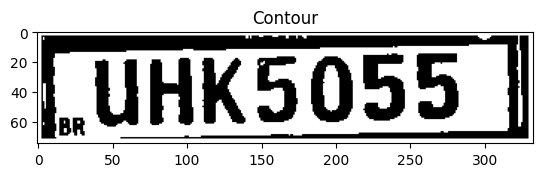

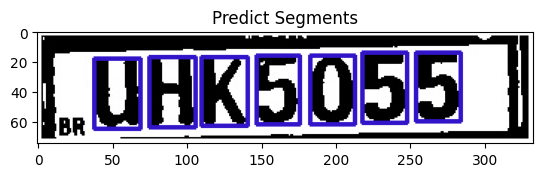

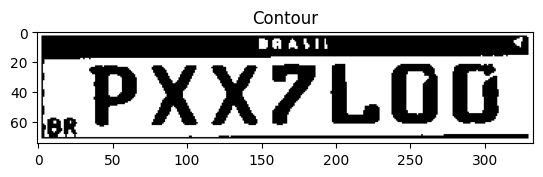

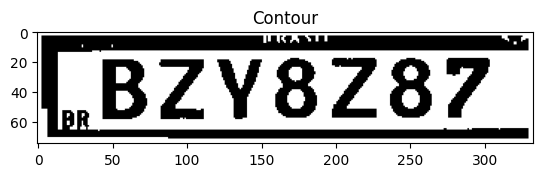

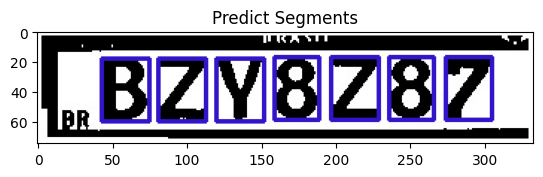

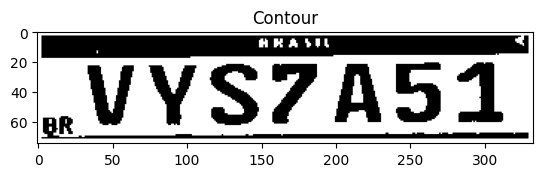

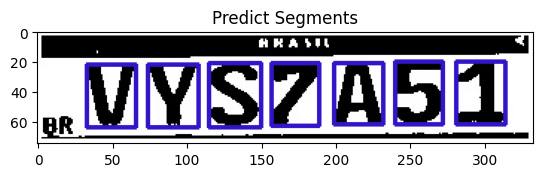

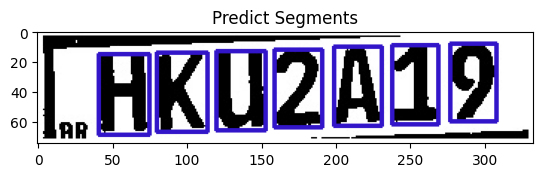

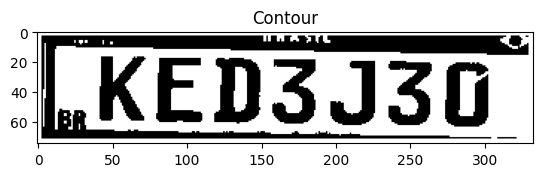

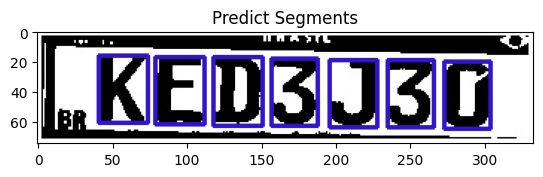

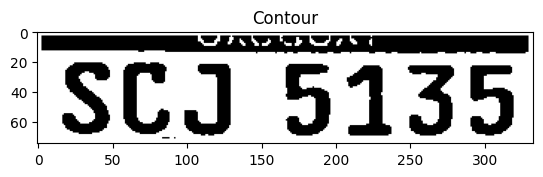

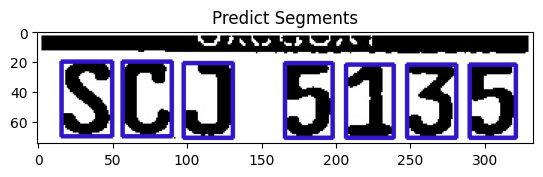

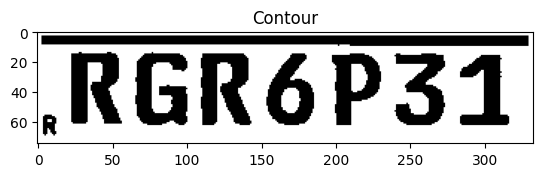

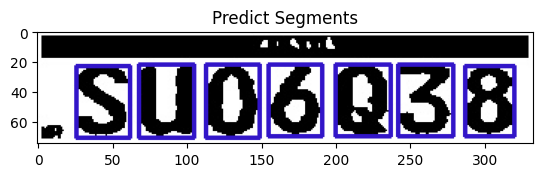

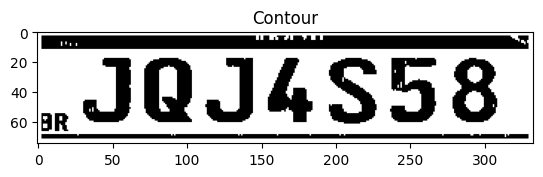

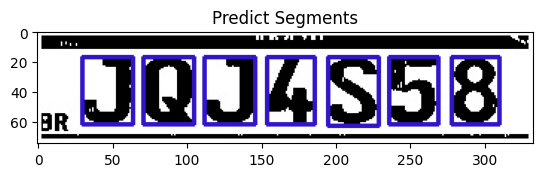

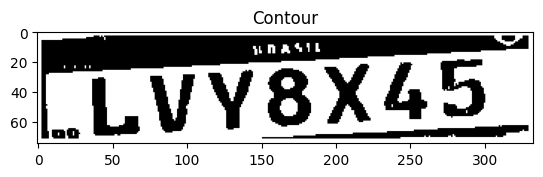

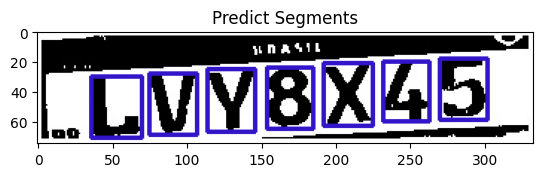

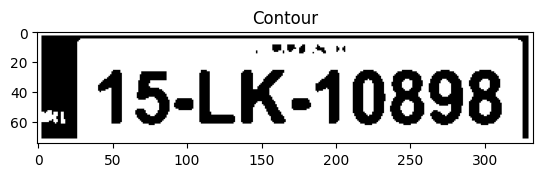

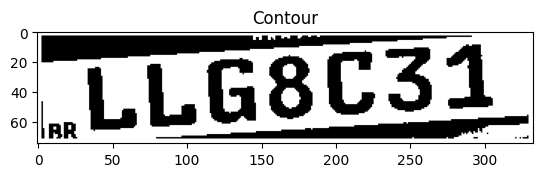

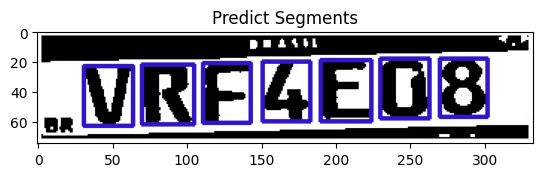

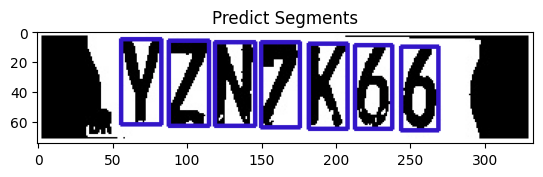

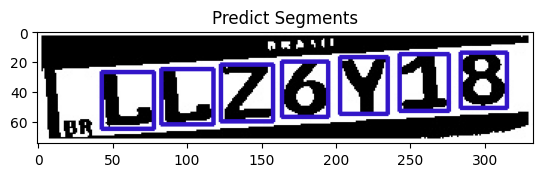

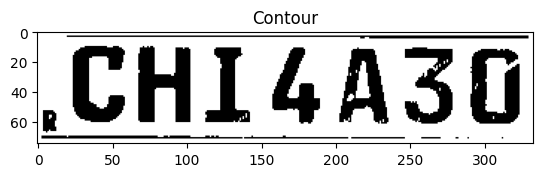

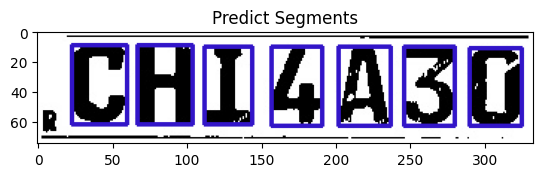

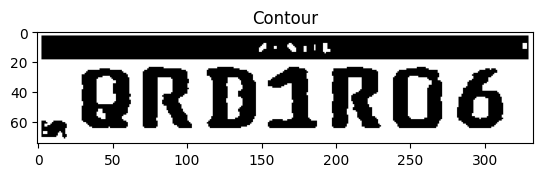

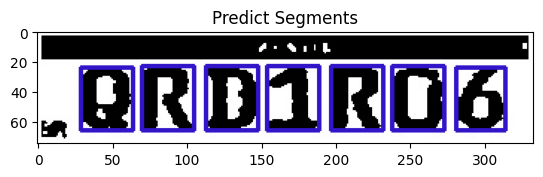

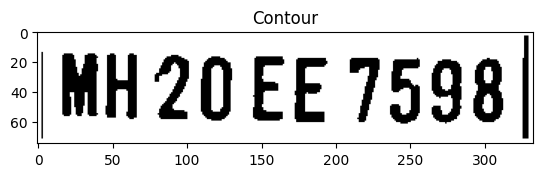

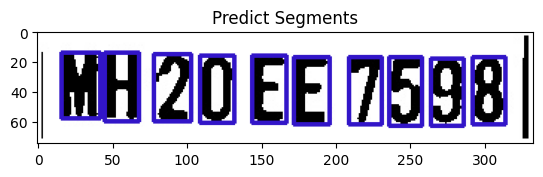

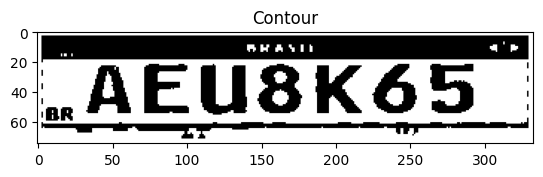

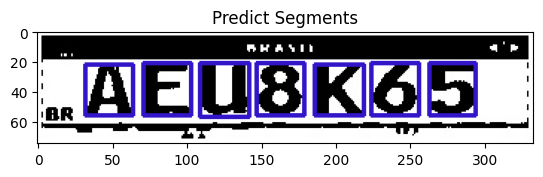

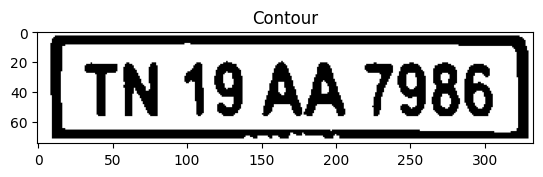

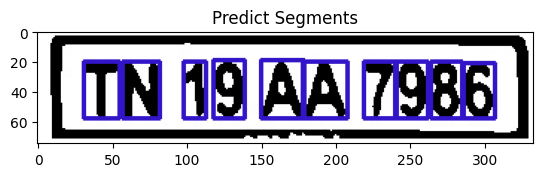

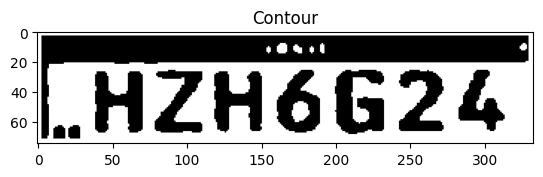

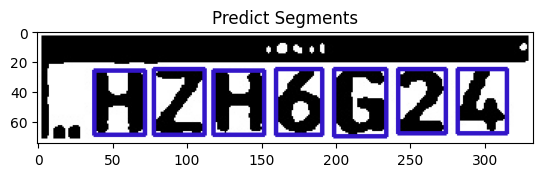

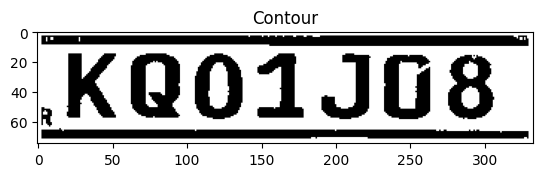

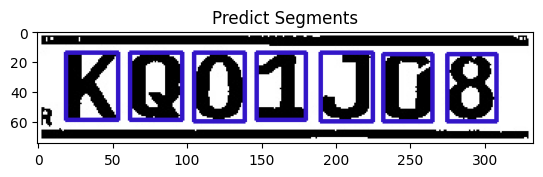

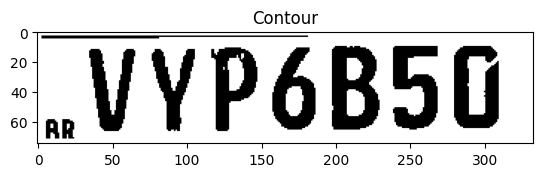

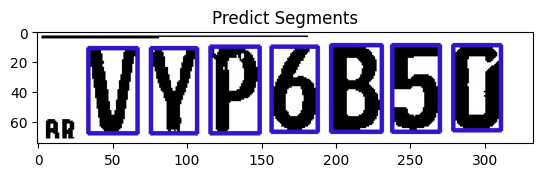

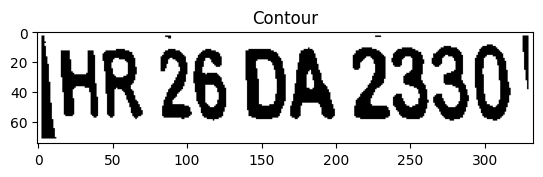

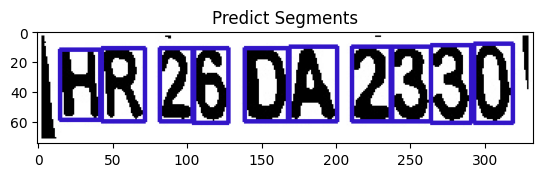

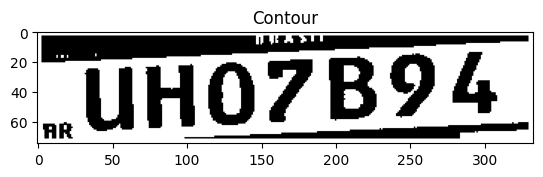

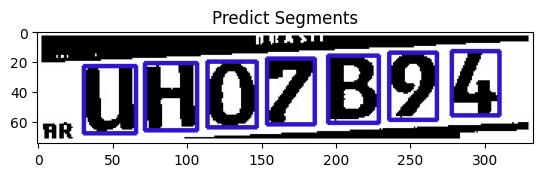

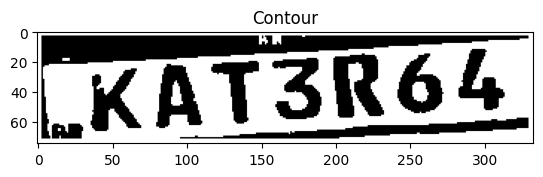

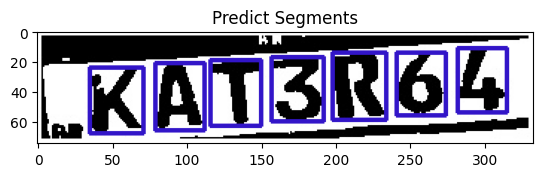

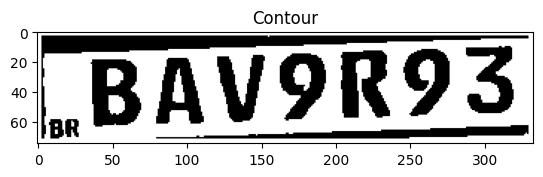

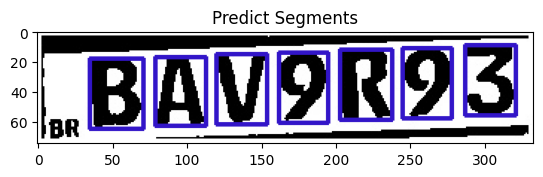

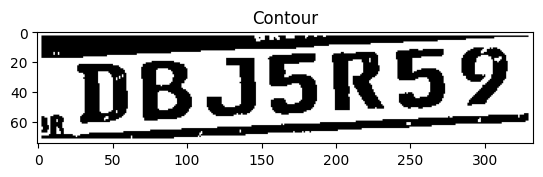

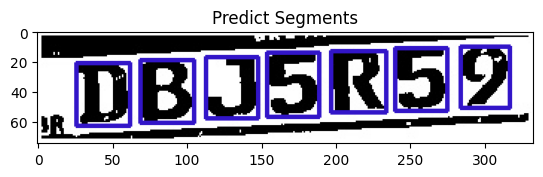

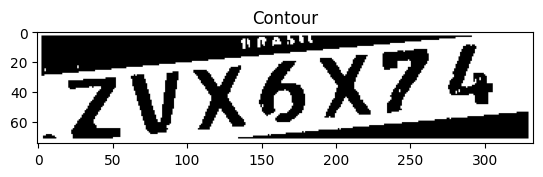

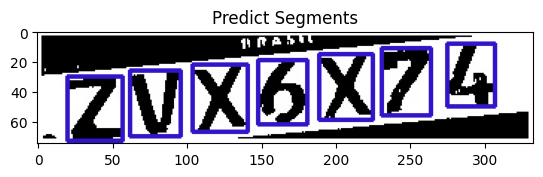

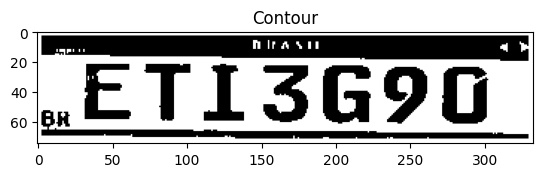

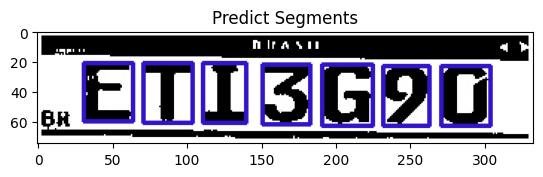

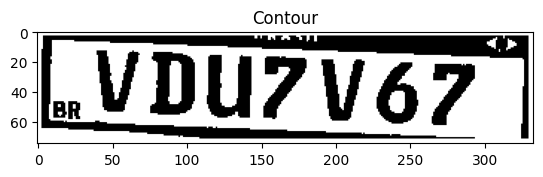

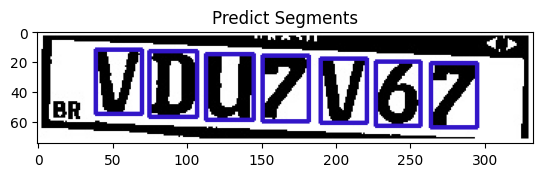

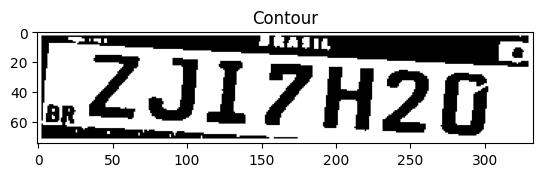

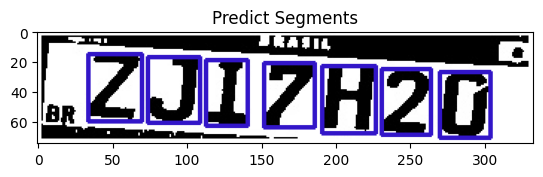

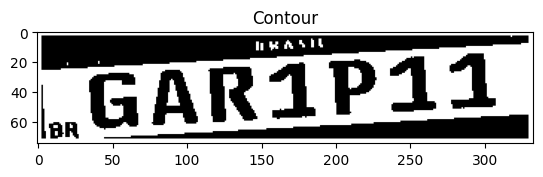

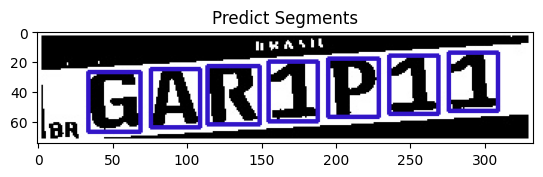

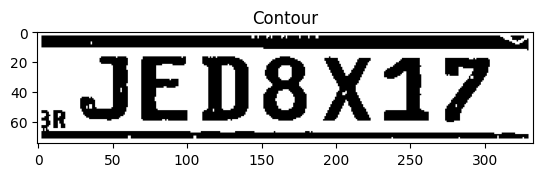

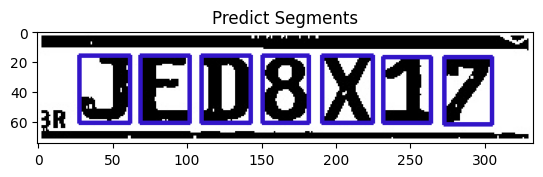

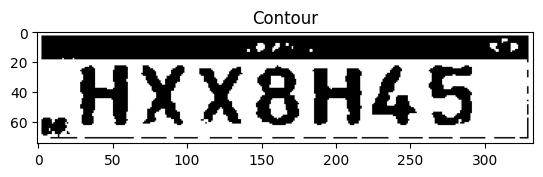

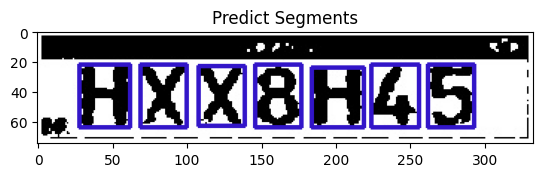

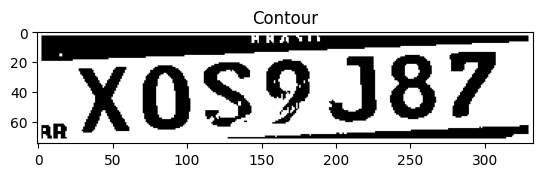

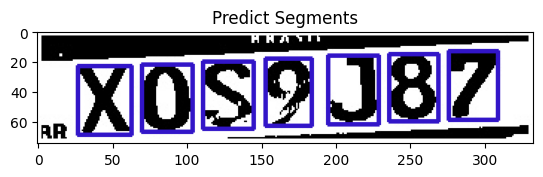

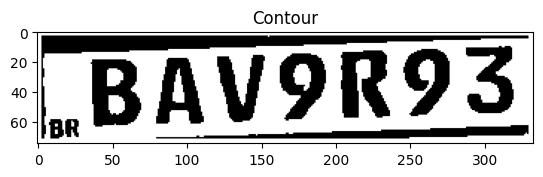

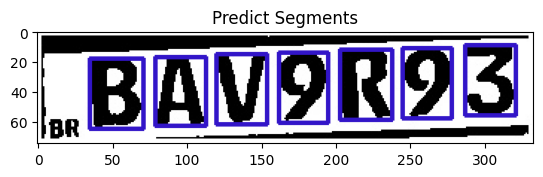

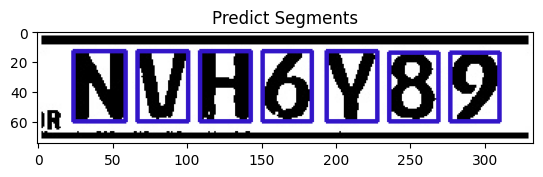

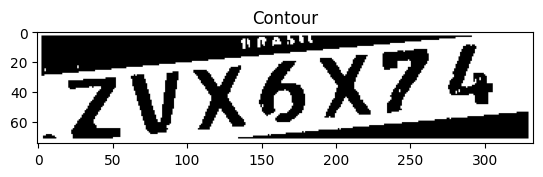

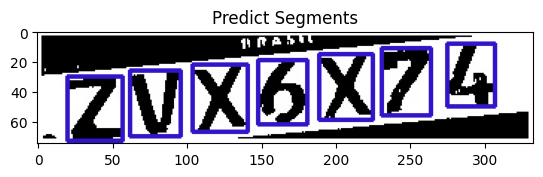

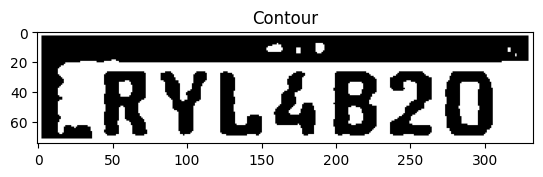

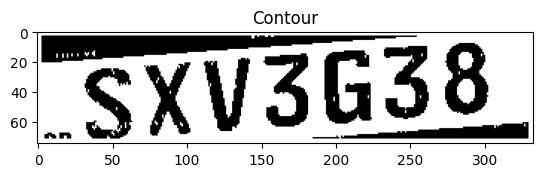

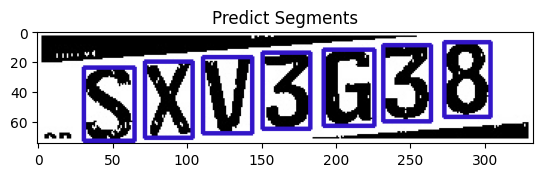

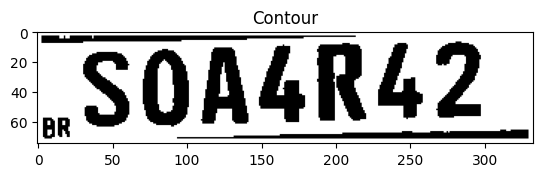

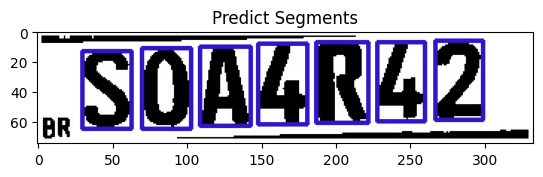

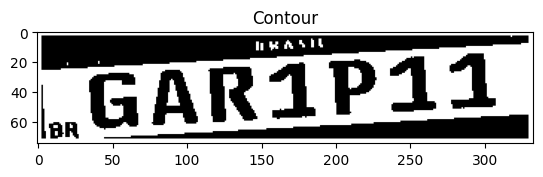

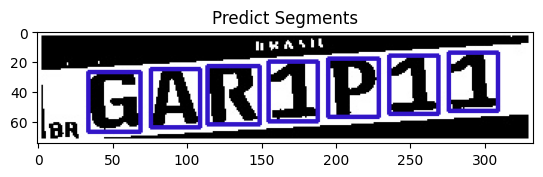

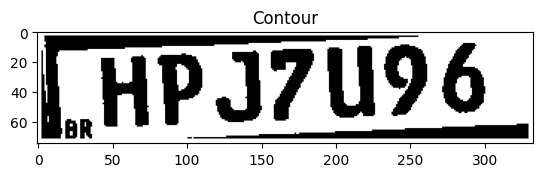

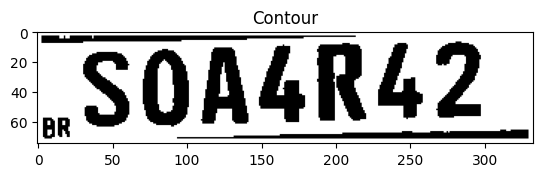

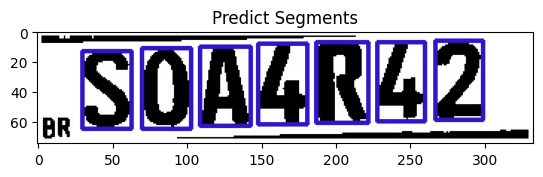

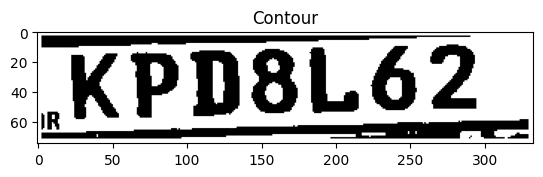

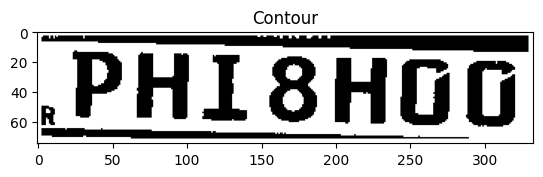

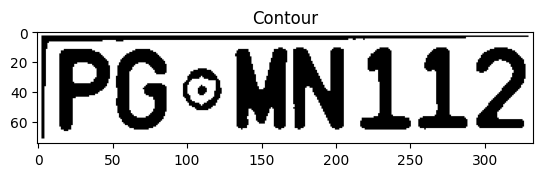

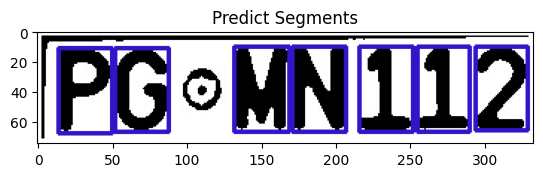

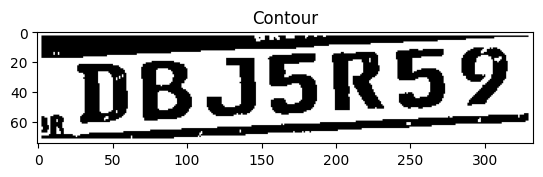

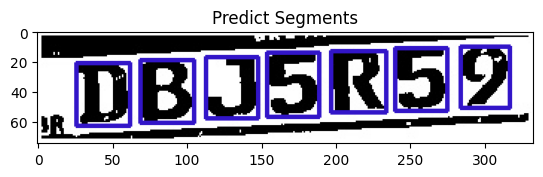

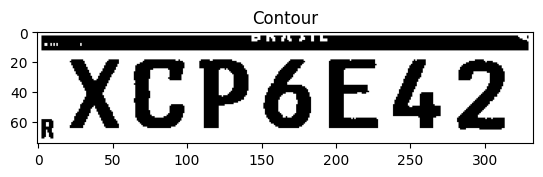

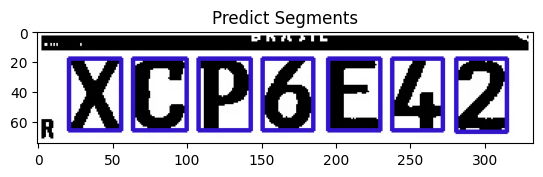

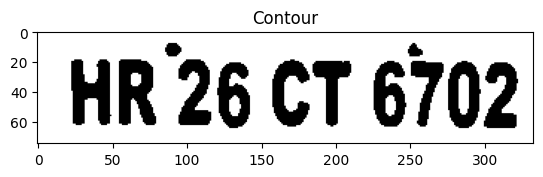

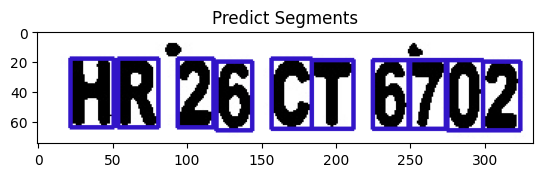

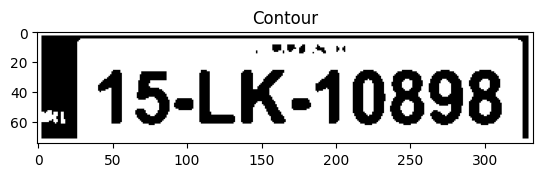

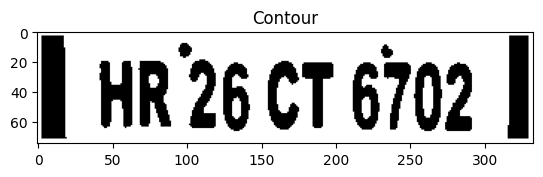

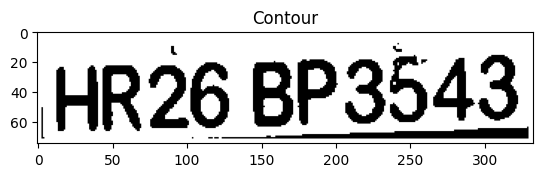

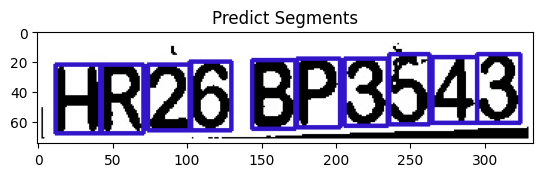

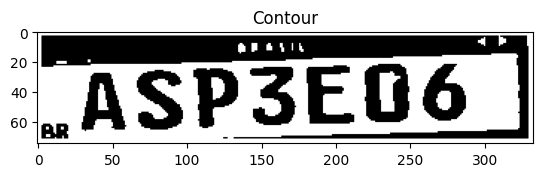

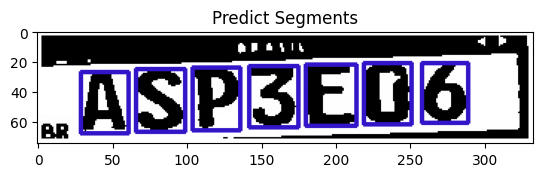

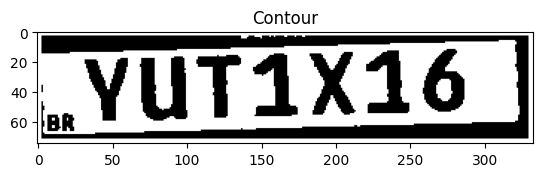

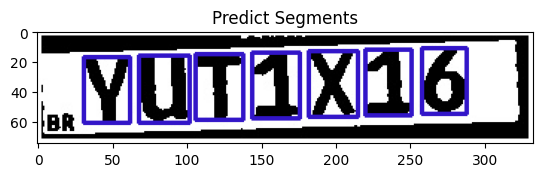

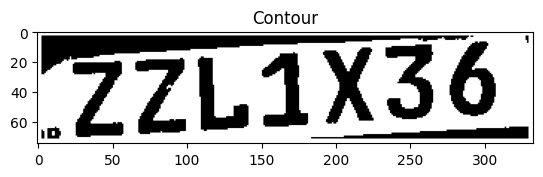

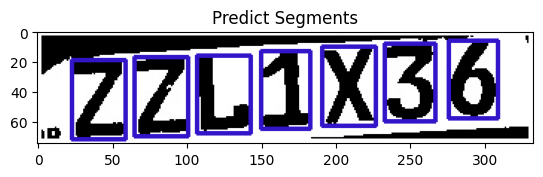

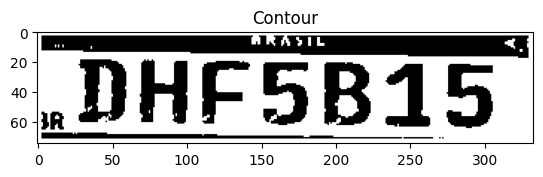

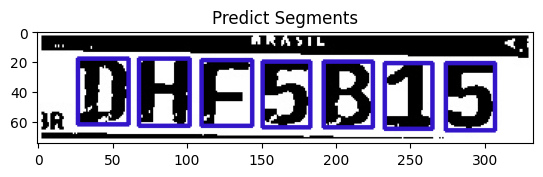

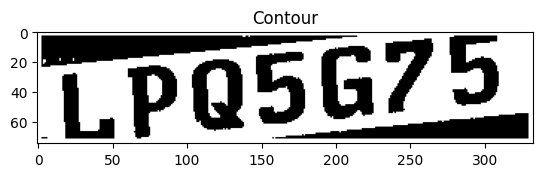

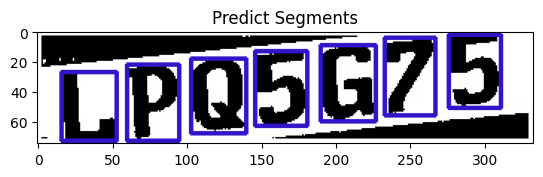

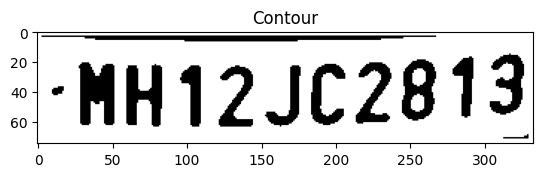

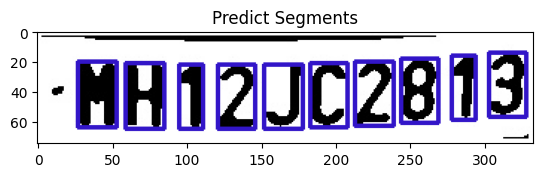

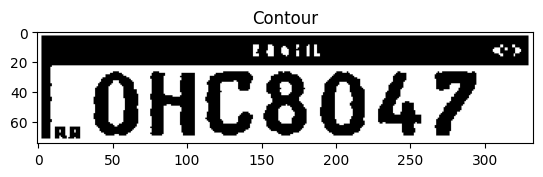

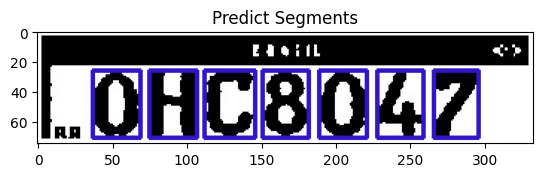

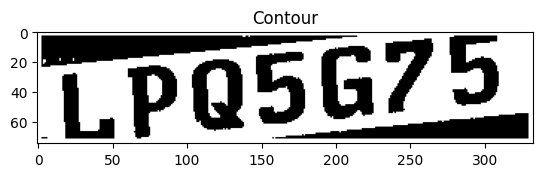

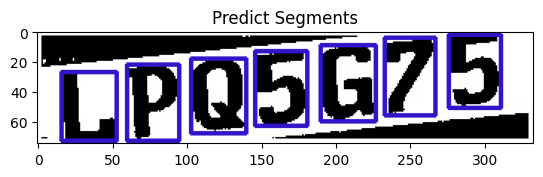

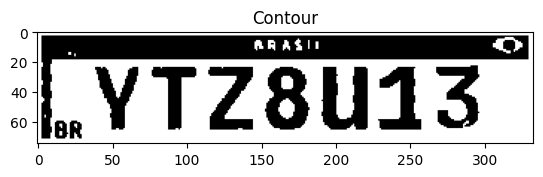

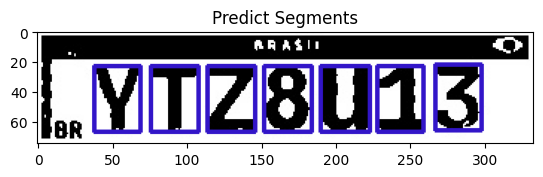

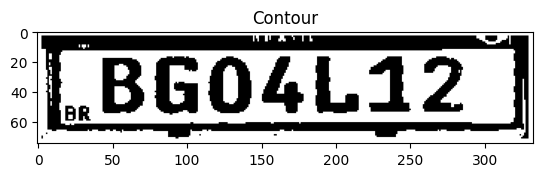

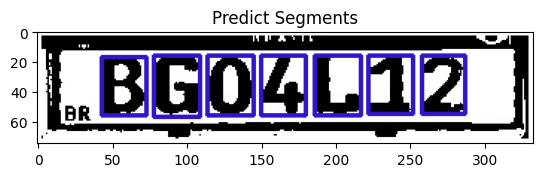

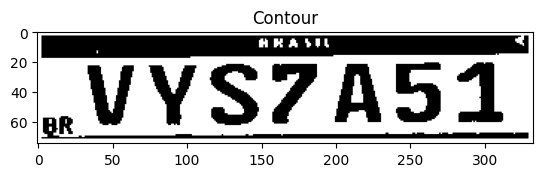

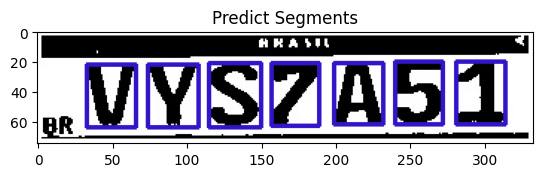

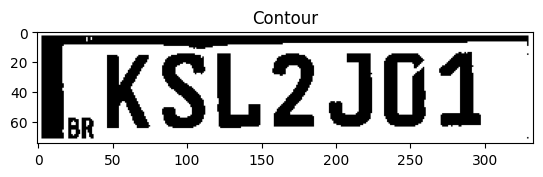

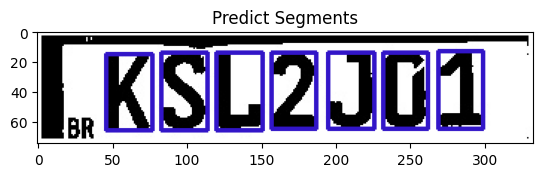

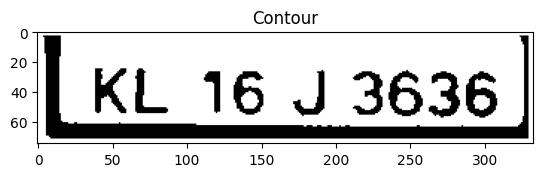

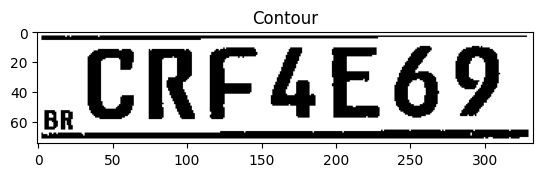

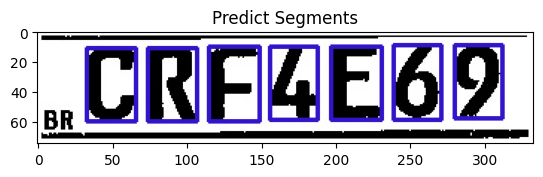

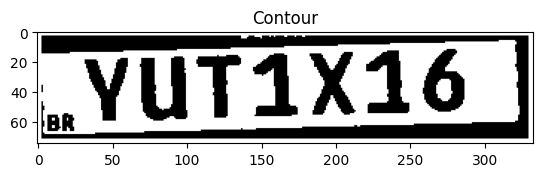

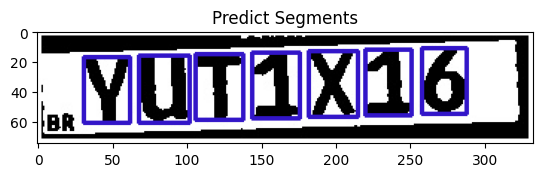

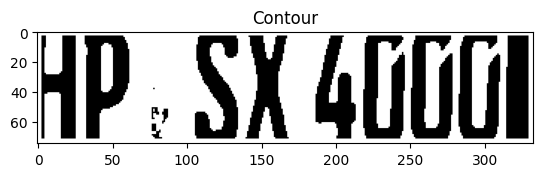

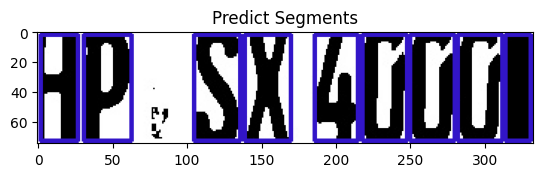

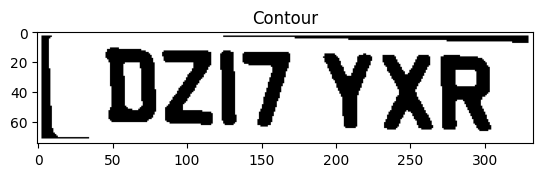

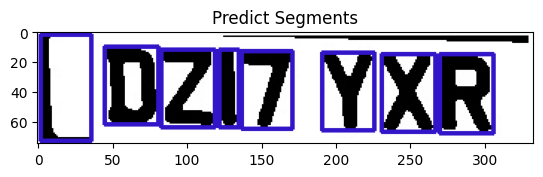

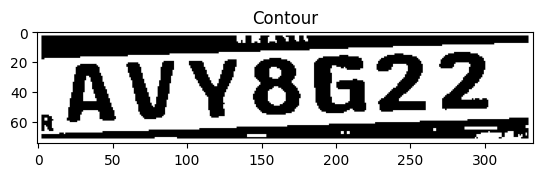

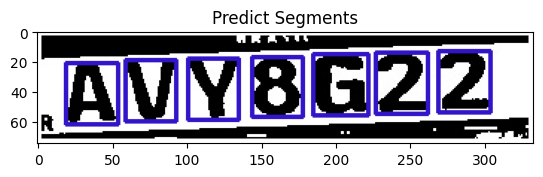

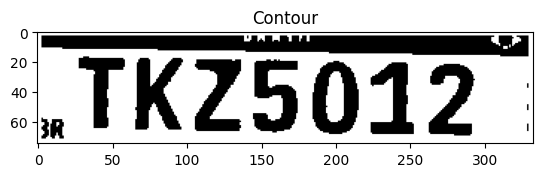

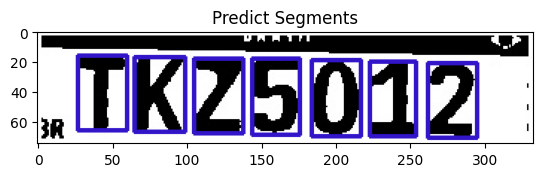

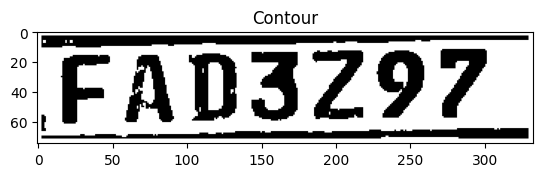

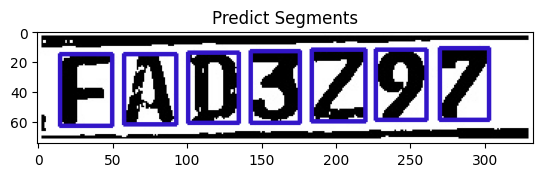

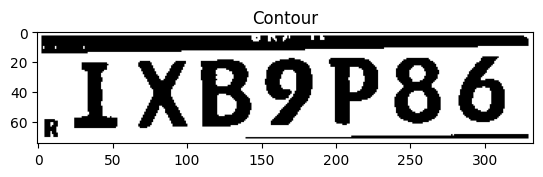

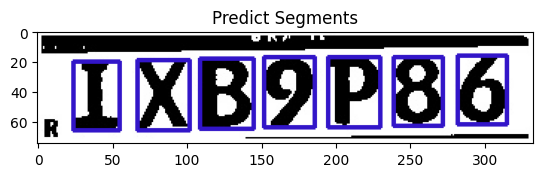

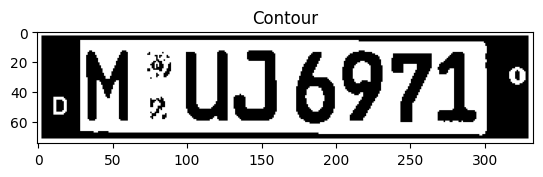

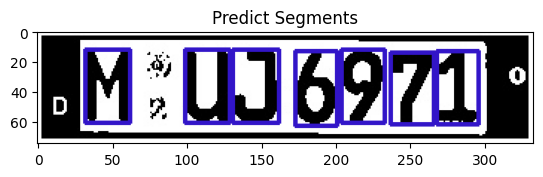

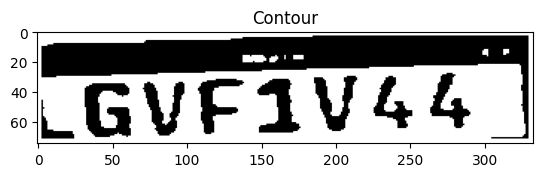

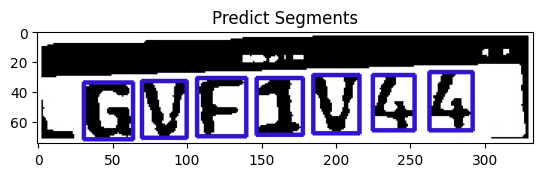

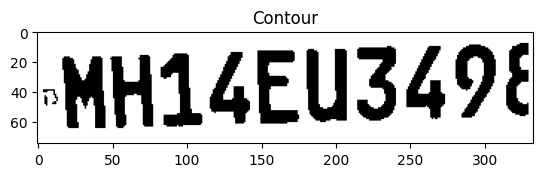

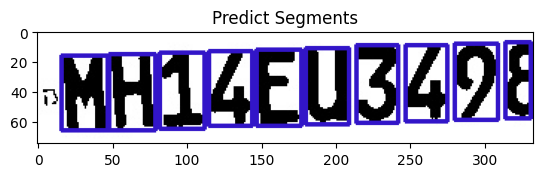

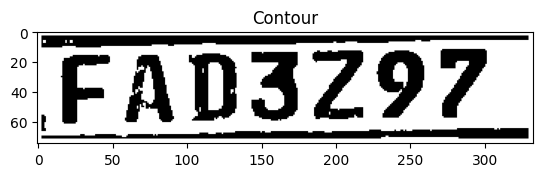

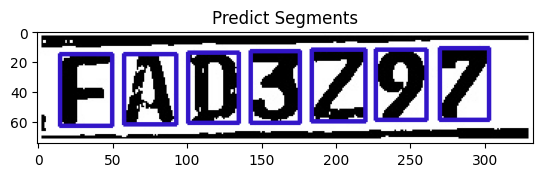

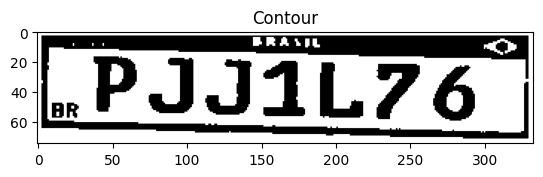

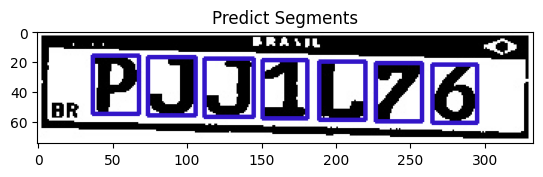

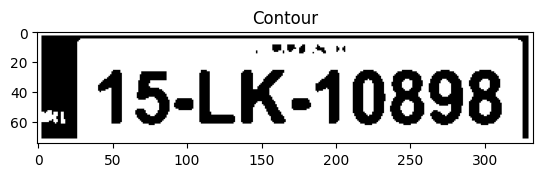

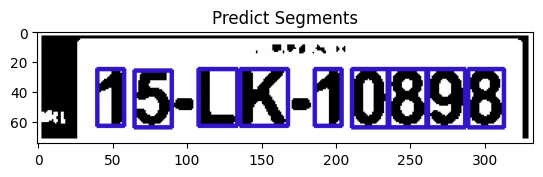

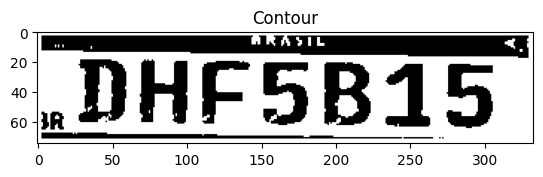

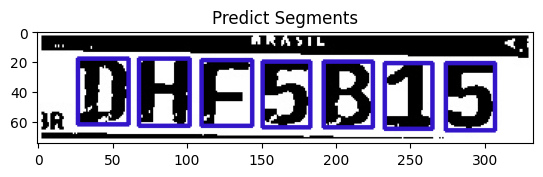

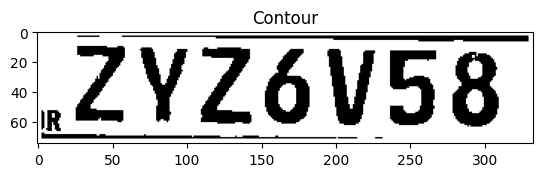

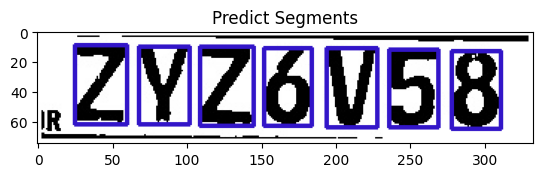

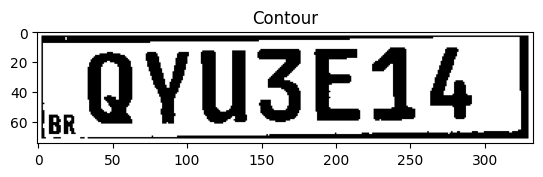

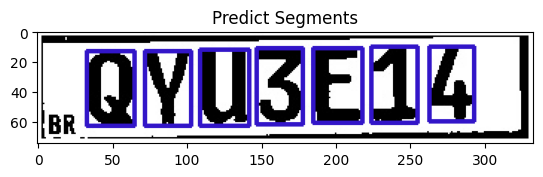

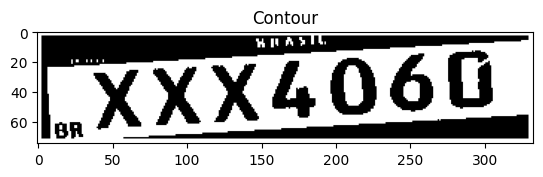

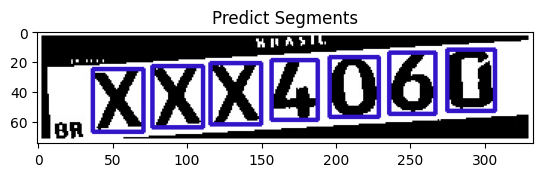

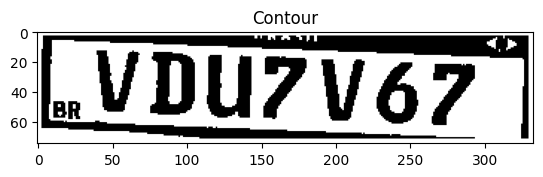

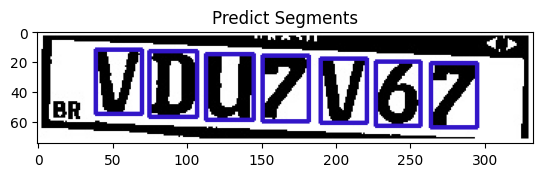

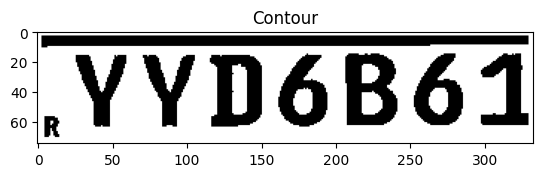

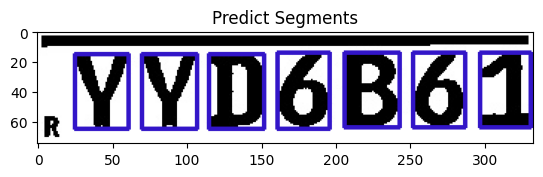

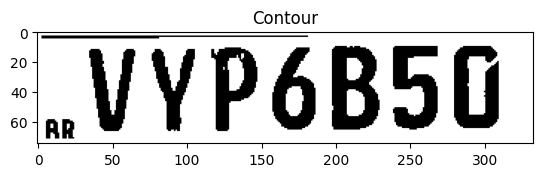

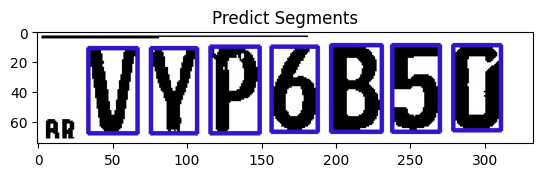

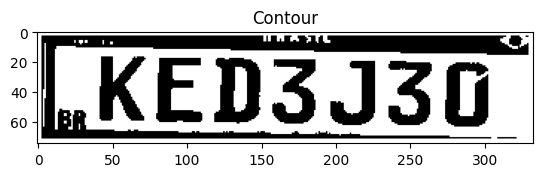

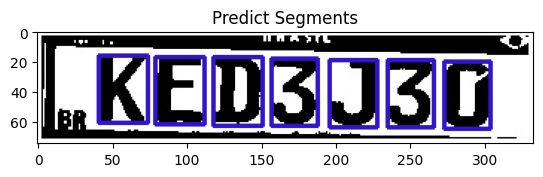

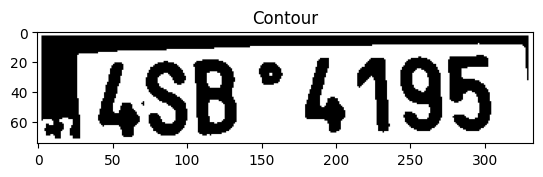

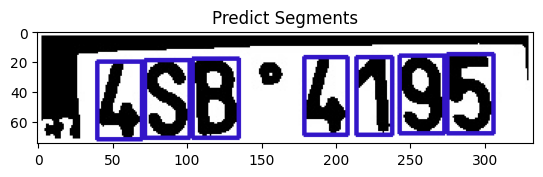

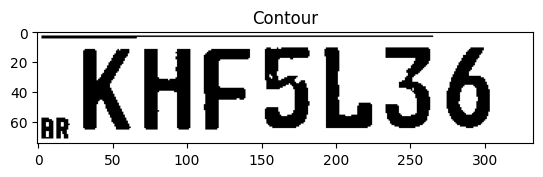

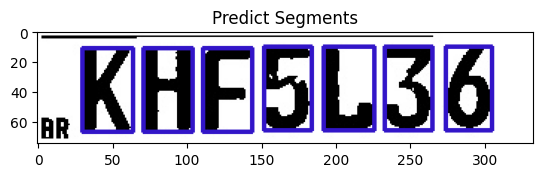

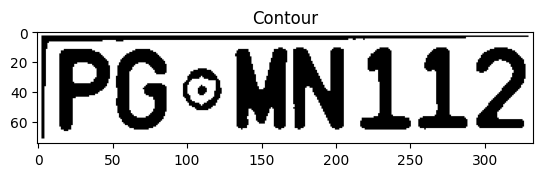

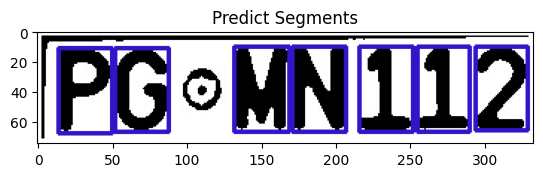

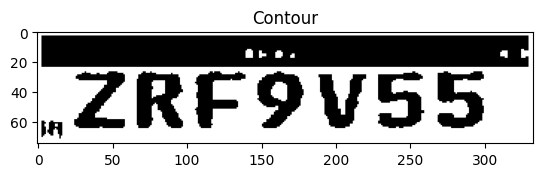

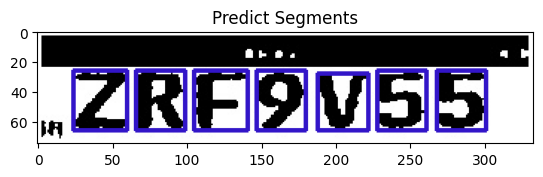

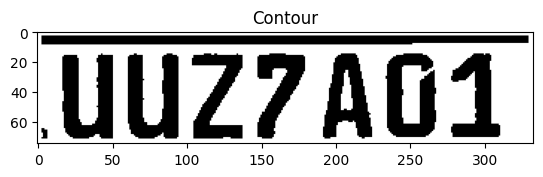

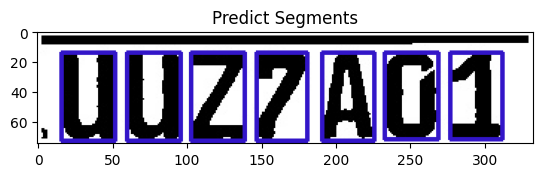

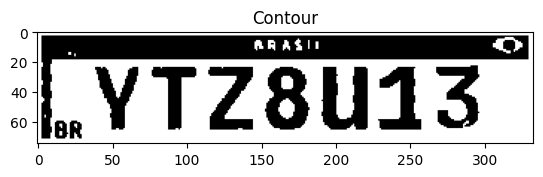

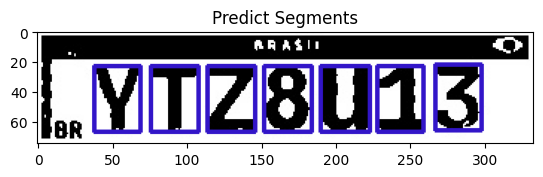

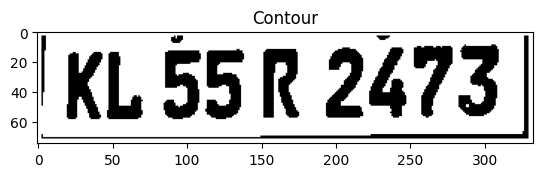

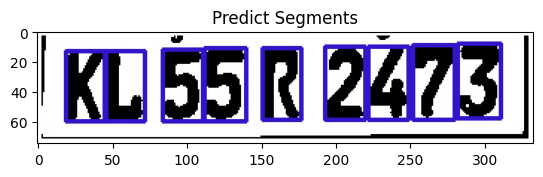

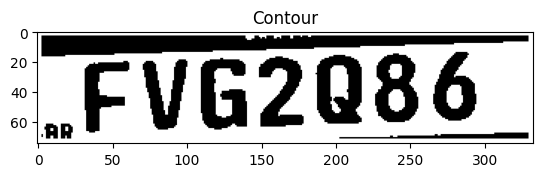

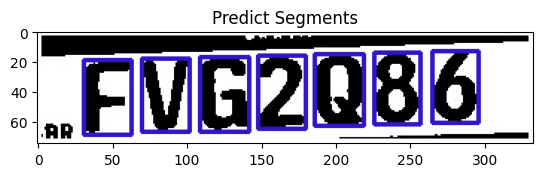

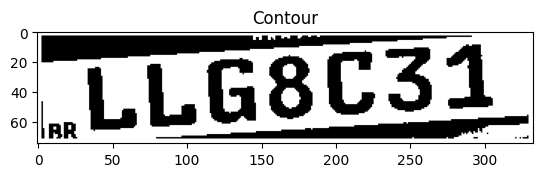

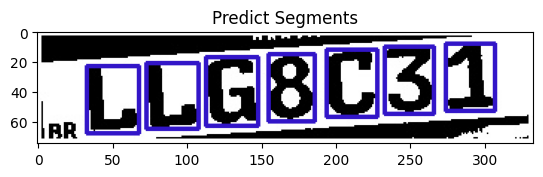

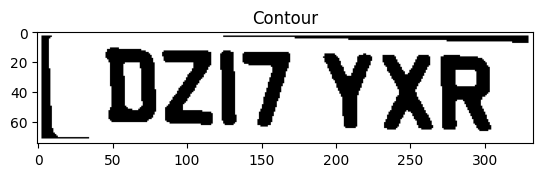

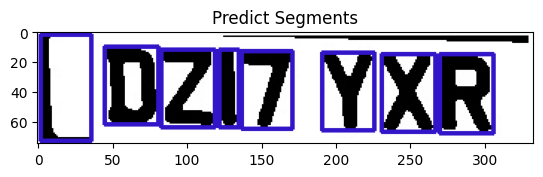

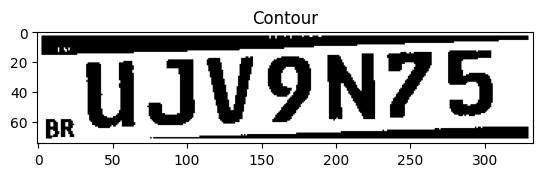

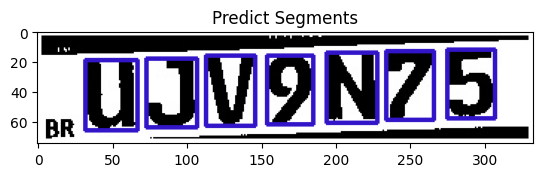

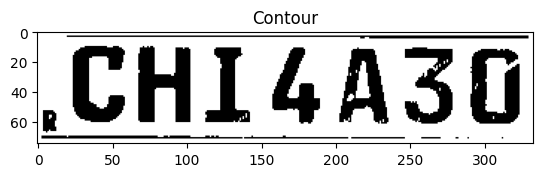

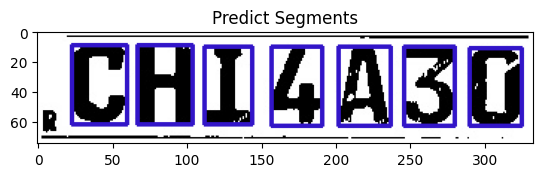

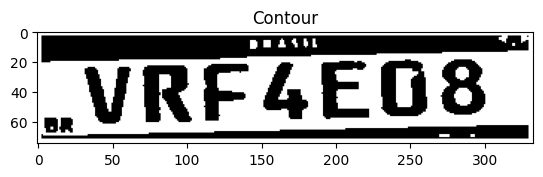

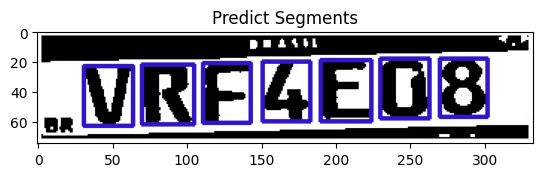

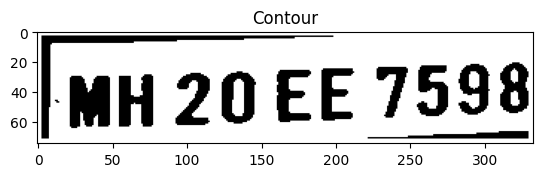

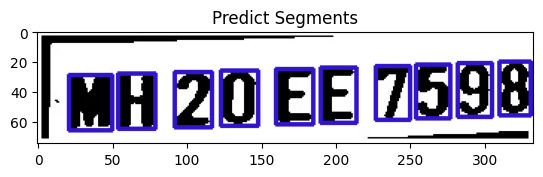

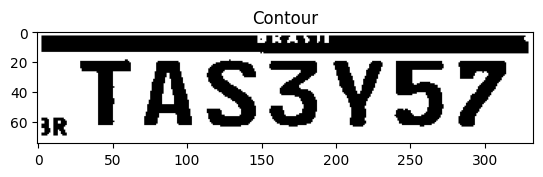

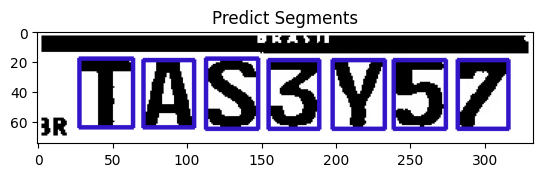

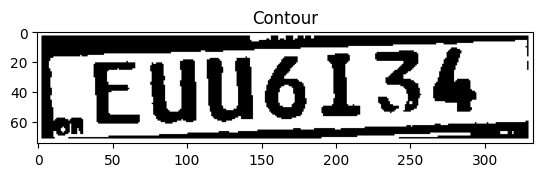

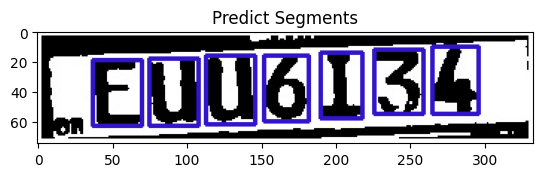

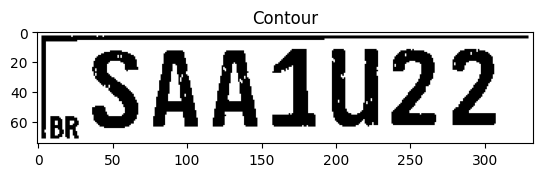

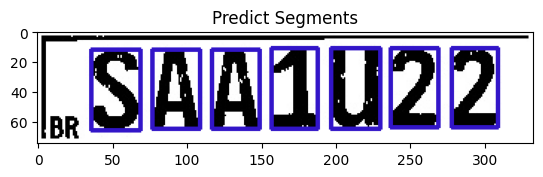

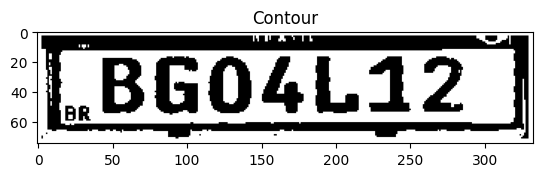

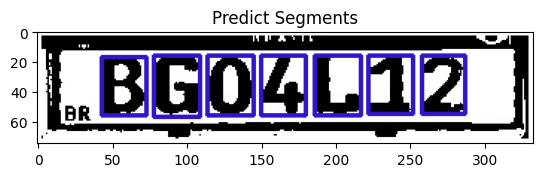

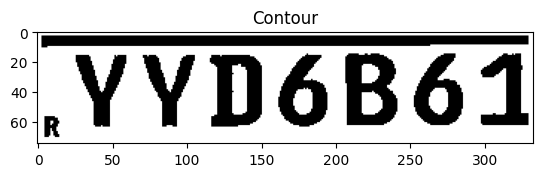

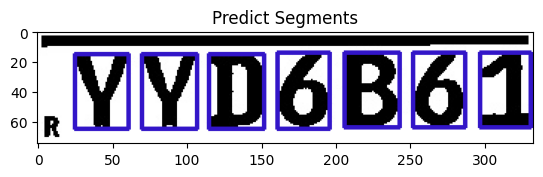

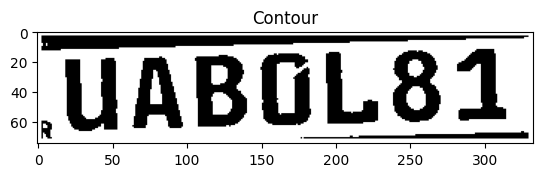

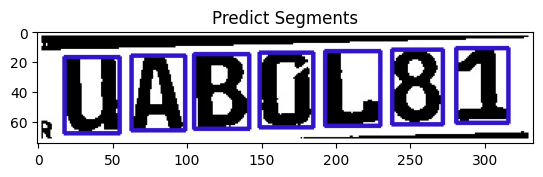

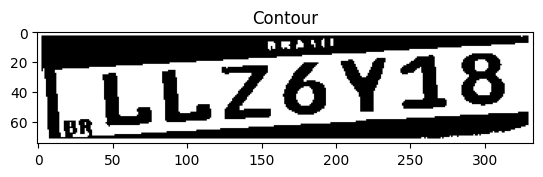

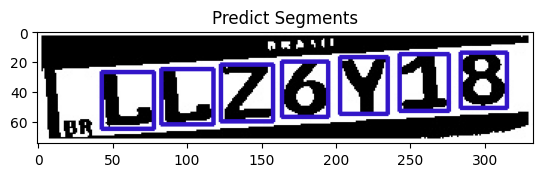

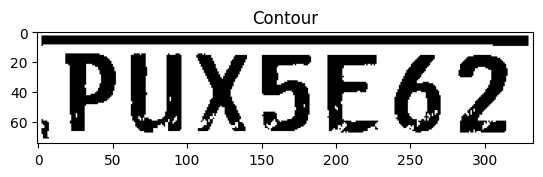

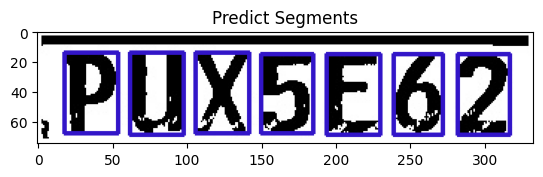

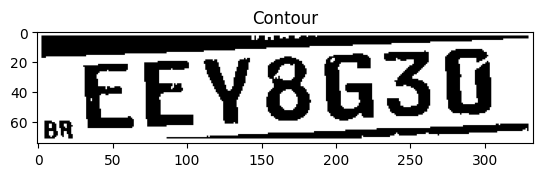

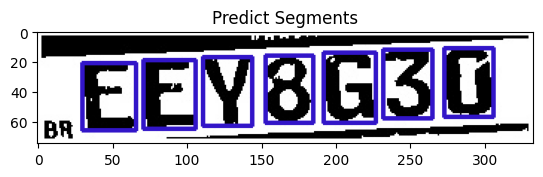

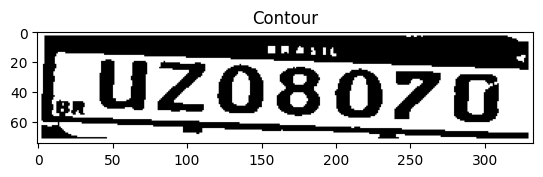

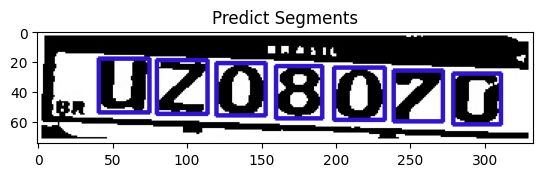

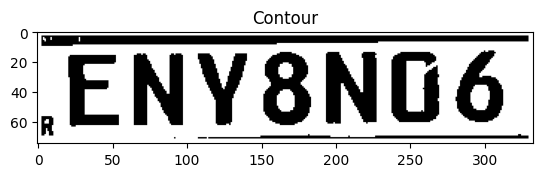

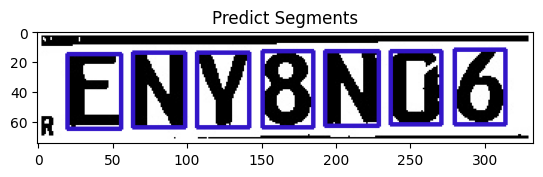

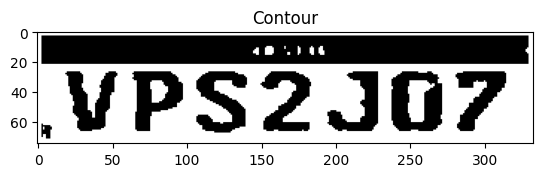

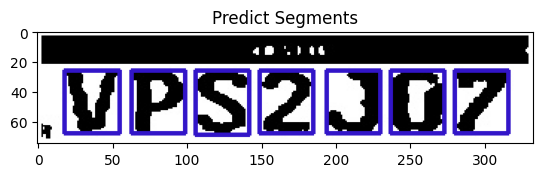

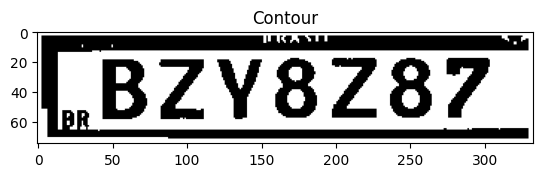

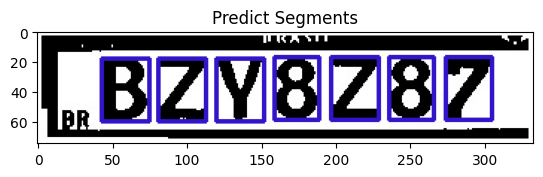

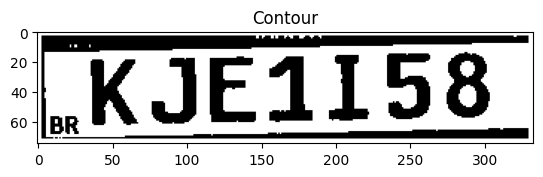

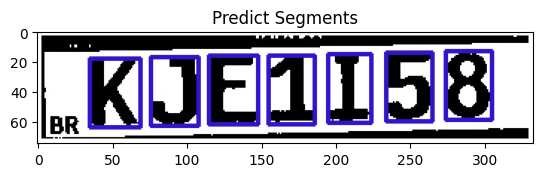

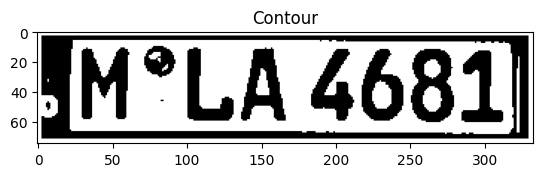

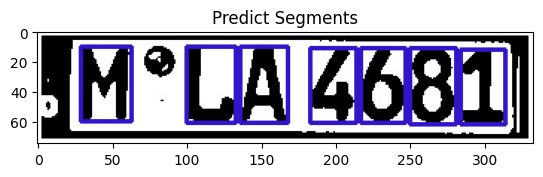

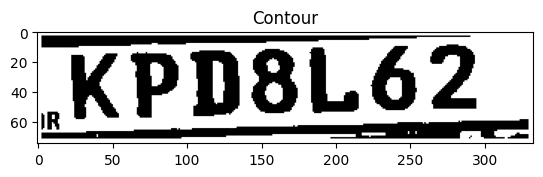

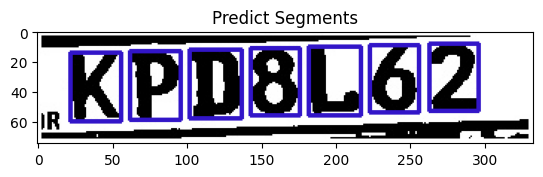

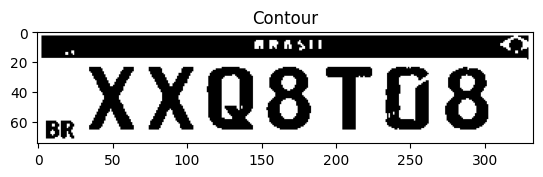

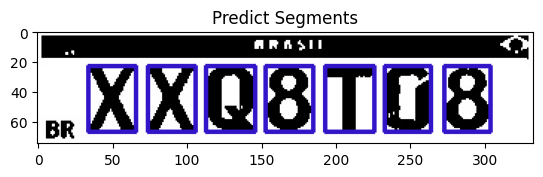

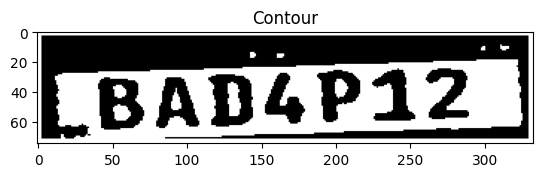

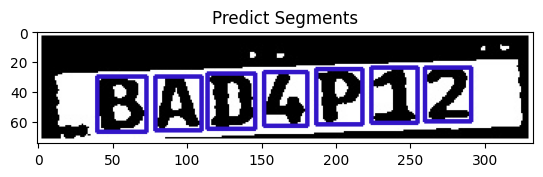

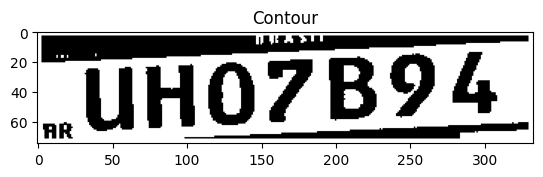

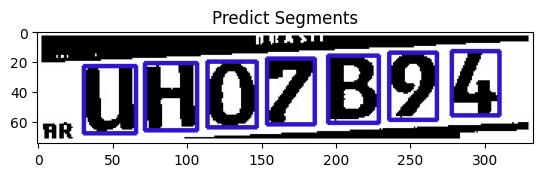

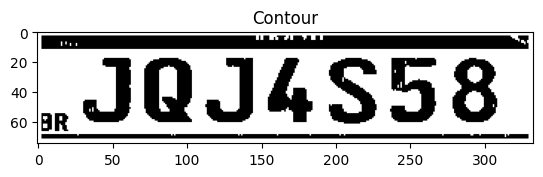

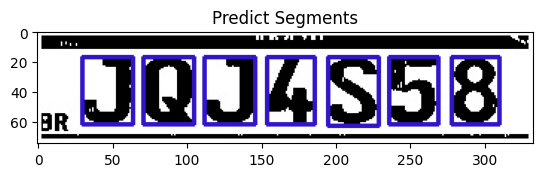

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [56]:
file_list=os.listdir(r"test_dataset/images")
count=0
for path in file_list:

    input_path = 'test_dataset/images/'+path
    is_video = False
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    
    cap = cv2.VideoCapture(input_path)
    
    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:

        
        hasFrame, frame = cap.read() 

        
        if not hasFrame:
            break

        
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        
        net.setInput(blob)

        
        outs = net.forward(getOutputsNames(net))

        
        cropped = postprocess(frame, outs)
        if cropped is not None:
            
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            
            char=segment_characters(cropped)
            
            count=show_results()
print("Accuracy: "+str((count/166)*100)+"%")